# Nighttime Lights Trends in Ethiopia

This notebook provides an analysis on the temporal and spatial patterns of nighttime lights trends in Ethiopia from 2012 to 2024. The analysis includes visualizations of nighttime lights trends at national and regional levels.

## Methodology

We created a time series of weekly radiance using NASA's Black Marble data which involves several steps, including data acquisition, pre-processing, zonal statistics calculation, and time series generation. The zonal statistics of the aggregated sum of nighttime lights is used to make inferences. 

This notebook uses NASA's Collection-2.

In [1]:
import os
from datetime import datetime

# import colorcet as cc
import folium
import geopandas
import pandas as pd

# from blackmarble.extract import bm_extract
from bokeh.models import HoverTool, Legend, Range1d, Span, Title
from bokeh.plotting import figure, output_notebook, show

%load_ext autoreload
%autoreload 2

**Region of Interest**

In [2]:
ethiopia_adm1 = geopandas.read_file(
    "../../data/boundaries/Region_14/Regions_14.shp"
)
ethiopia_adm2 = geopandas.read_file(
    "../../boundaries/adm2_mapped.geojson"
)

ethiopia_adm3 = geopandas.read_file(
    "../../boundaries/adm3_mapped.geojson"
)
# ethiopia.explore()

In [33]:
import numpy as np

def get_annual_percent_change(
    df, group_columns=["ADM1_EN"], baseline_year="PY", column="ntl_sum"
):
    df = df.copy()
    df["year"] = df["date"].dt.year
    baseline_column = f"baseline_{column}_{baseline_year}"
    column_name = f"percent_change_{column}_{baseline_year}"

    if isinstance(baseline_year, int):  # Fixed baseline year case
        baseline_df = (
            df[df["year"] == baseline_year]
            .groupby(group_columns)[column]
            .mean()
            .reset_index()
            .rename(columns={column: baseline_column})
        )
        df = df.merge(baseline_df, on=group_columns, how="left")
        # Replace zero baseline with np.nan to avoid division by zero
        df[baseline_column] = df[baseline_column].replace(0, np.nan)
        df[column_name] = ((df[column] - df[baseline_column]) / df[baseline_column]) * 100

    elif baseline_year == "PY":  # Previous year case
        df[baseline_column] = None
        years = sorted(df["year"].unique())
        for year in years[1:]:
            baseline_df = (
                df[df["year"] == year - 1]
                .groupby(group_columns)[column]
                .mean()
                .reset_index()
                .rename(columns={column: baseline_column})
            )
            df.loc[df["year"] == year, baseline_column] = (
                df.loc[df["year"] == year, group_columns]
                .merge(baseline_df, on=group_columns, how="left")[baseline_column]
                .values
            )
            # Replace zero baseline with np.nan to avoid division by zero
            df.loc[df["year"] == year, baseline_column] = df.loc[df["year"] == year, baseline_column].replace(0, np.nan)
            df.loc[df["year"] == year, column_name] = ((df.loc[df["year"] == year, column] - df.loc[df["year"] == year, baseline_column]) / df.loc[df["year"] == year, baseline_column]) * 100

    else:
        raise ValueError(
            "Invalid baseline_year argument. Use an integer for a fixed year or 'PY' for previous year."
        )

    return df


In [29]:
import numpy as np

def get_monthly_percent_change(
    df, group_columns=[], baseline_year="PY", column="ntl_sum"
):
    df = df.copy()
    df["year"] = df["date"].dt.year
    df["month"] = df["date"].dt.month
    baseline_column = f"baseline_{column}_{baseline_year}"
    column_name = f"percent_change_{column}_{baseline_year}"

    if isinstance(baseline_year, int):  # Fixed baseline year case
        # Compute monthly NO2 baseline for the specified baseline year
        baseline_df = (
            df[df["year"] == baseline_year]
            .groupby(group_columns + ["month"])[column]
            .mean()
            .reset_index()
            .rename(columns={column: baseline_column})
        )

        # Merge the fixed-year baseline into the original DataFrame
        df = df.merge(baseline_df, on=group_columns + ["month"], how="left")

        # Robust percent change calculation: avoid division by zero
        df[column_name] = np.where(
            (df[baseline_column] == 0) | (df[baseline_column].isna()),
            np.nan,
            ((df[column] - df[baseline_column]) / df[baseline_column]) * 100,
        )

    elif baseline_year == "PY":  # Previous year case
        df[baseline_column] = None  # Initialize column for baseline NO2 values

        # Get all unique years in the dataset
        years = sorted(df["year"].unique())

        # Iterate through each year (starting from the second year in the dataset)
        for year in years[1:]:  # Ensure there's a previous year
            # Compute the previous year's monthly baseline
            baseline_df = (
                df[df["year"] == year - 1]  # Get the previous year's data
                .groupby(group_columns + ["month"])[column]
                .mean()
                .rename(baseline_column)
            )

            # Use .map() to assign the previous year's NO2 values correctly
            df.loc[df["year"] == year, baseline_column] = df.loc[
                df["year"] == year, group_columns + ["month"]
            ].apply(
                lambda row: baseline_df.get(
                    tuple(row[group_columns]) + (row["month"],)
),
                axis=1,
            )

            # Robust percent change calculation: avoid division by zero
            df.loc[df["year"] == year, column_name] = np.where(
                (df.loc[df["year"] == year, baseline_column] == 0) | (df.loc[df["year"] == year, baseline_column].isna()),
                np.nan,
                ((df.loc[df["year"] == year, column] - df.loc[df["year"] == year, baseline_column]) / df.loc[df["year"] == year, baseline_column]) * 100,
            )

    else:
        raise ValueError(
            "Invalid baseline_year argument. Use an integer for a fixed year or 'PY' for previous year."
        )

    column_name = f"percent_change_{column}_{baseline_year}"

    # Compute the monthly percentage change

    return df


In [18]:
ntl_adm0_monthly = pd.read_csv("../../ntl-collection2/ntl_adm0_monthly_collection2.csv")
ntl_adm1_monthly = pd.read_csv("../../ntl-collection2/ntl_adm1_monthly_collection2.csv")
ntl_adm2_monthly = pd.read_csv("../../ntl-collection2/ntl_adm2_monthly_collection2.csv")

ntl_adm0_monthly.drop(columns=['Unnamed: 0'], inplace=True)
ntl_adm1_monthly.drop(columns=['Unnamed: 0'], inplace=True)
ntl_adm2_monthly.drop(columns=['Unnamed: 0'], inplace=True)

ntl_adm0_monthly['date'] = pd.to_datetime(ntl_adm0_monthly['date'])
ntl_adm1_monthly['date'] = pd.to_datetime(ntl_adm1_monthly['date'])
ntl_adm2_monthly['date'] = pd.to_datetime(ntl_adm2_monthly['date'])

In [148]:
ntl_adm0_annual = pd.read_csv('../../ntl-collection2/ethiopia_adm0_annual_2019_2025_collection2.csv')
ntl_adm1_annual = pd.read_csv('../../ntl-collection2/ethiopia_adm1_annual_2019_2025_collection2.csv')
ntl_adm2_annual = pd.read_csv('../../ntl-collection2/ntl_adm2_annual_collection2.csv')

ntl_adm0_annual['date'] = pd.to_datetime(ntl_adm0_annual['date'])
ntl_adm1_annual['date'] = pd.to_datetime(ntl_adm1_annual['date'])
ntl_adm2_annual['date'] = pd.to_datetime(ntl_adm2_annual['date'])

#ntl_adm0_annual.drop(columns=['Unnamed: 0'], inplace=True)
#ntl_adm1_annual.drop(columns=['Unnamed: 0'], inplace=True)
ntl_adm2_annual.drop(columns=['Unnamed: 0'], inplace=True)

In [150]:
# ntl_adm0_monthly = get_monthly_percent_change(
#     ntl_adm0_monthly, baseline_year=2019, column="ntl_sum", group_columns=["ADM0_EN"]
# )
# ntl_adm0_monthly = get_monthly_percent_change(
#     ntl_adm0_monthly, baseline_year="PY", column="ntl_sum", group_columns=["ADM0_EN"]
# )

# ntl_adm1_monthly = get_monthly_percent_change(
#     ntl_adm1_monthly,
#     baseline_year=2019,
#     column="ntl_sum",
#     group_columns=["ADM1_EN"],
# )
# ntl_adm1_monthly = get_monthly_percent_change(
#     ntl_adm1_monthly,
#     baseline_year="PY",
#     column="ntl_sum",
#     group_columns=[ "ADM1_EN"],
# )

# # ntl_admin2_monthly = get_monthly_percent_change(ntl_admin2_monthly, baseline_year=2019, column='ntl_sum', group_columns=['COUNTRY', 'NAME_1', 'NAME_2'])
# # ntl_admin2_monthly = get_monthly_percent_change(ntl_admin2_monthly, baseline_year='PY', column='ntl_sum', group_columns=['COUNTRY', 'NAME_1', 'NAME_2'])

ntl_adm0_annual = get_annual_percent_change(
    ntl_adm0_annual, baseline_year=2019, column="ntl_sum", group_columns=["ADM0_EN"]
)
ntl_adm0_annual = get_annual_percent_change(
    ntl_adm0_annual, baseline_year="PY", column="ntl_sum", group_columns=["ADM0_EN"]
)

# ntl_adm1_annual = get_annual_percent_change(
#     ntl_adm1_annual,
#     baseline_year=2019,
#     column="ntl_sum",
#     group_columns=["ADM1_EN"],
# )
# ntl_adm1_annual = get_annual_percent_change(
#     ntl_adm1_annual,
#     baseline_year="PY",
#     column="ntl_sum",
#     group_columns=["ADM1_EN"],
# )

# ntl_adm2_annual = get_annual_percent_change(
#     ntl_adm2_annual,
#     baseline_year=2019,
#     column="ntl_sum",
#     group_columns=["ADM1_EN", "ADM2_EN"],
# )
# ntl_adm2_annual = get_annual_percent_change(
#     ntl_adm2_annual,
#     baseline_year="PY",
#     column="ntl_sum",
#     group_columns=["ADM1_EN", "ADM2_EN"],
# )

In [125]:
wb = pd.read_csv("../../data/general/API_ETH_DS2_en_csv_v2_6837.csv", skiprows=4)

In [128]:
population = wb[wb["Indicator Code"].isin(["SP.POP.TOTL"])]
gdp = wb[wb["Indicator Code"].isin(["NY.GDP.PCAP.CD", "NY.GDP.MKTP.CD", "NY.GDP.MKTP.KD"])]


In [129]:
gdp = (
    gdp.drop(columns=["Country Code", "Country Name", "Indicator Code"])
    .set_index("Indicator Name")
    .T.reset_index()
)
gdp = gdp.rename(columns={"index": "Year"})
gdp = gdp.dropna(subset="GDP per capita (current US$)")
gdp["Year"] = pd.to_datetime(gdp["Year"], format="%Y")
gdp = gdp[["Year", "GDP (current US$)", "GDP per capita (current US$)", "GDP (constant 2015 US$)"]]

In [131]:
population = (
    population.drop(columns=["Country Code", "Country Name", "Indicator Code"])
    .set_index("Indicator Name")
    .T.reset_index()
)
population = population.rename(columns={"index": "Year"})
population = population.dropna(subset="Population, total")
population["Year"] = pd.to_datetime(population["Year"], format="%Y")

### Insights

#### National Trends of Nighttime Lights

In [154]:
import bokeh
from bokeh.core.validation.warnings import EMPTY_LAYOUT, MISSING_RENDERERS
from bokeh.io import output_notebook, show
from bokeh.models import Span
import pandas as pd
from bokeh.plotting import figure
from bokeh.models import Panel, Tabs, TabPanel

bokeh.core.validation.silence(MISSING_RENDERERS, True)
from acled_conflict_analysis import visuals


output_notebook()

df = ntl_adm0_annual.sort_values(by='date')
#df["date"] = pd.to_datetime(df["date"])

tabs = []

for measure in ["ntl_sum", "percent_change_ntl_sum_2019", "percent_change_ntl_sum_PY"]:
    # Get the line plot for monthly NO2
    p = visuals.get_line_plot(
        df,
        "Annual National Nighttime Lights",
        "Source: NASA BlackMarble. World Bank estimates",
        # subtitle = "",
        category="ADM0_EN",
        measure=measure,
        event_date="date",
    )

    tab = TabPanel(child=p, title=measure)
    tabs.append(tab)

# Show the plot with both the monthly and yearly average lines
tabs = Tabs(tabs=tabs, sizing_mode="scale_both")
show(tabs, warn_on_missing_glyphs=False)


Loading BokehJS ...

In [153]:
import bokeh
from bokeh.core.validation.warnings import MISSING_RENDERERS
from bokeh.io import output_notebook, show
from bokeh.models import Span, Range1d, LinearAxis
from bokeh.plotting import figure
from bokeh.models import Panel, Tabs, TabPanel, Label
import pandas as pd
from acled_conflict_analysis import visuals

bokeh.core.validation.silence(MISSING_RENDERERS, True)

output_notebook()

df = ntl_adm0_annual.sort_values(by='date')
df["date"] = pd.to_datetime(df["date"])
ntl_adm0_annual = ntl_adm0_annual.sort_values(by='date')

tabs = []

# Loop through comparative data
for comparative, column_name in [(gdp, "GDP (constant 2015 US$)"), (population, "Population, total")]:
    # Correctly filter comparative data starting from 2012
    comparative = comparative[comparative["Year"] >= pd.Timestamp("2012-01-01")]
    #print(column_name)

    ntl_min = df["ntl_sum"].min()
    ntl_max = df["ntl_sum"].max()

    # Create the figure
    p = figure(
        title=f"Annual National Nighttime Lights Compared with {column_name}",
        x_axis_label="Year",
        y_axis_label="Nighttime Lights",
        x_axis_type="datetime",
        width=800,
        height=400,
        sizing_mode=None,
        y_range=Range1d(start=ntl_min, end=ntl_max),
    )

    # Plot the primary data (NTL)
    p.line(
        x=ntl_adm0_annual["date"],
        y=ntl_adm0_annual["ntl_sum"],
        line_width=2,
        color="blue",
        legend_label="NTL Sum",
    )

    # Configure the secondary axis with independent range
    secondary_min = comparative[comparative.columns[1]].min()
    secondary_max = comparative[comparative.columns[1]].max()
    p.extra_y_ranges = {"secondary": Range1d(start=secondary_min, end=secondary_max)}
    p.add_layout(
        LinearAxis(y_range_name="secondary", axis_label=column_name), "right"
    )

    # Plot the comparative data on the secondary axis
    p.line(
        x=comparative["Year"],
        y=comparative[column_name],
        line_width=2,
        color="red",
        y_range_name="secondary",
        legend_label=column_name,
    )

    subtitle = Label(
        x=-0.1,
        y=-3,
        x_units="screen",
        y_units="screen",
        text="Source: NASA BlackMarble and World Bank estimates",
        text_font_size="10pt",
        text_align="left",
    )
    p.add_layout(subtitle)

    # Add the tab
    tab = TabPanel(child=p, title=column_name)
    tabs.append(tab)

# Create and display the tabs
tabs_layout = Tabs(tabs=tabs, sizing_mode=None)
show(tabs_layout)


Loading BokehJS ...

**The Population and GDP of the country shows a similar increase as in NTL. However, the dips ain 2019 and 2019 and the rise in 2017 is not seen.** The last available year for this data is also 2023. 

In [152]:
import bokeh
from bokeh.core.validation.warnings import EMPTY_LAYOUT, MISSING_RENDERERS
from bokeh.io import output_notebook, show
from bokeh.models import Span
import pandas as pd
from bokeh.plotting import figure
from bokeh.models import Panel, Tabs, TabPanel

bokeh.core.validation.silence(MISSING_RENDERERS, True)
from acled_conflict_analysis import visuals


output_notebook()

df = ntl_adm0_monthly.copy().sort_values(by='date')
df["date"] = pd.to_datetime(df["date"])
df = df.rename(columns={"date": "event_date"})

tabs = []

for measure in ["ntl_sum", "percent_change_ntl_sum_2019", "percent_change_ntl_sum_PY"]:
    # Get the line plot for monthly NO2
    p = visuals.get_bar_chart(
        df,
        "Monthly National Nighttime Lights",
        "Source: NASA BlackMarble. World Bank estimates",
        category="ADM0_EN",
        measure=measure,
        category_value="Ethiopia",
        color_code="#1AA1DB",
        width=1500000000,
    )

    # # Add a line for yearly averages
    # # Assuming you have a way to map the 'year' values to a datetime format for the x-axis in the plot
    # p.children[1].line(x=pd.to_datetime(ntl_admin0_annual['event_date'].dt.year, format='%Y'), y=ntl_admin0_annual[measure],
    #     line_width=2, color='red', legend_label=f'Yearly Average {measure}')

    tab = TabPanel(child=p, title=measure)
    tabs.append(tab)

# Show the plot with both the monthly and yearly average lines
tabs = Tabs(tabs=tabs, sizing_mode="scale_both")
show(tabs, warn_on_missing_glyphs=False)


Loading BokehJS ...

**All percentage change values consider 2019 as a baseline year. 2024 saw a reduction in lights compared to 2023**

#### Percentage change in subnational annual nighttime lights compared to PY

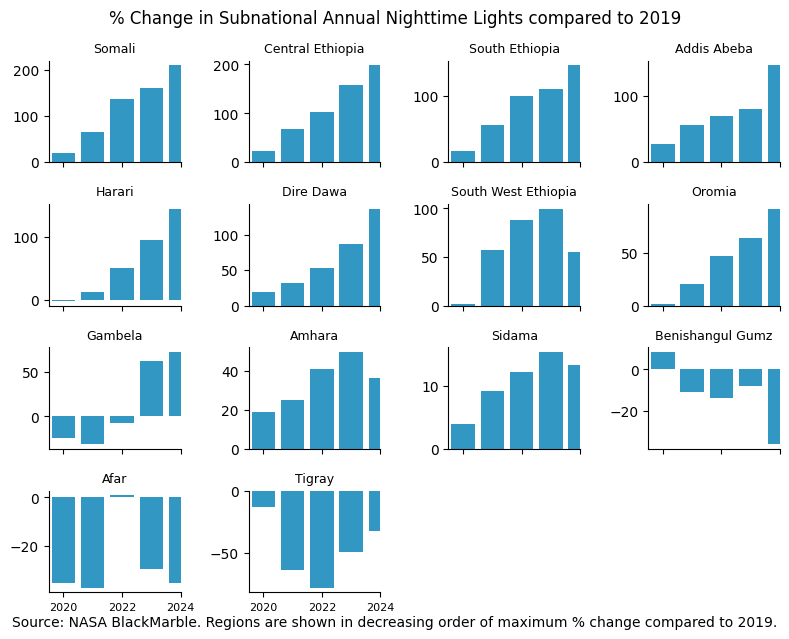

In [109]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MultipleLocator

ntl_adm1_annual.dropna(subset=["ADM1_EN"], inplace=True)

# Calculate vmax for each region and sort regions in decreasing order
region_vmax = ntl_adm1_annual.groupby("ADM1_EN")["percent_change_ntl_sum_2019"].max().sort_values(ascending=False)
sorted_regions = region_vmax.index.tolist()

fig, axes = plt.subplots(4, 4, figsize=(8, 6), sharex=True)  # 4x3 grid (extra space for alignment)
axes = axes.flatten()

# Create bar charts for each region in sorted order
for i, region in enumerate(sorted_regions):
    ax = axes[i]
    df = ntl_adm1_annual[(ntl_adm1_annual["ADM1_EN"] == region)&(ntl_adm1_annual['date']>'2019-01-01')]
    df.loc[:, "year"] = pd.to_datetime(df["date"]).dt.year

    sns.barplot(
        data=df, x="year", y="percent_change_ntl_sum_2019", color="#1AA1DB", ax=ax
    )
    ax.set_title(region, fontsize=9)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # Set x-axis to show ticks every 2 years
    years = sorted(df["year"].unique())
    if len(years) > 0:
        min_year = min(years)
        max_year = max(years)
        # Create ticks starting from an even year, every 2 years
        start_year = min_year if min_year % 2 == 0 else min_year + 1
        tick_years = range(start_year, max_year + 1, 2)
        ax.set_xticks([i for i, year in enumerate(years) if year in tick_years])
        ax.set_xticklabels([str(year) for year in years if year in tick_years])
    
    ax.tick_params(axis="x", labelsize=8)

# Hide extra subplots if regions < grid cells and remove their grids
for j in range(len(sorted_regions), len(axes)):
    axes[j].set_visible(False)  # This completely hides the subplot including grid

# Adjust layout
plt.tight_layout()
plt.suptitle(
    "% Change in Subnational Annual Nighttime Lights compared to 2019", 
    x=0.5, y=1.03
)
# Add subtitle below the main title
plt.figtext(0.5, 0.002, "Source: NASA BlackMarble. Regions are shown in decreasing order of maximum % change compared to 2019.", ha="center", fontsize=10, color="black")
plt.show()
# plt.savefig('../../docs/images/ntl_admin1_monthly.png')

**Not all admin regions saw an increase in NTL compared to 2019.** Tigray region saw a reduction in lights since 2019. Afar and Benshangul-Gumaz saw little change in light from 2019. 

#### Trends in subnational annual nighttime lights

In [46]:
ntl_adm1_annual[ntl_adm1_annual['date']=='2024-01-01'].sort_values(by='percent_change_ntl_sum_PY')[['ADM1_EN','percent_change_ntl_sum_PY']]

ADM1_EN percent_change_ntl_sum_PY
3      Benishangul Gumz                -30.416632
10  South West Ethiopia                -22.262198
2                Amhara                 -8.793299
1                  Afar                   -8.1165
8                Sidama                 -1.805636
5               Gambela                  5.942801
13     Central Ethiopia                 15.476274
12       South Ethiopia                 16.570168
7                Oromia                 16.718353
9                Somali                 18.919882
6                Harari                 25.716076
4             Dire Dawa                  26.29337
11               Tigray                 31.710143
0           Addis Abeba                 36.831526

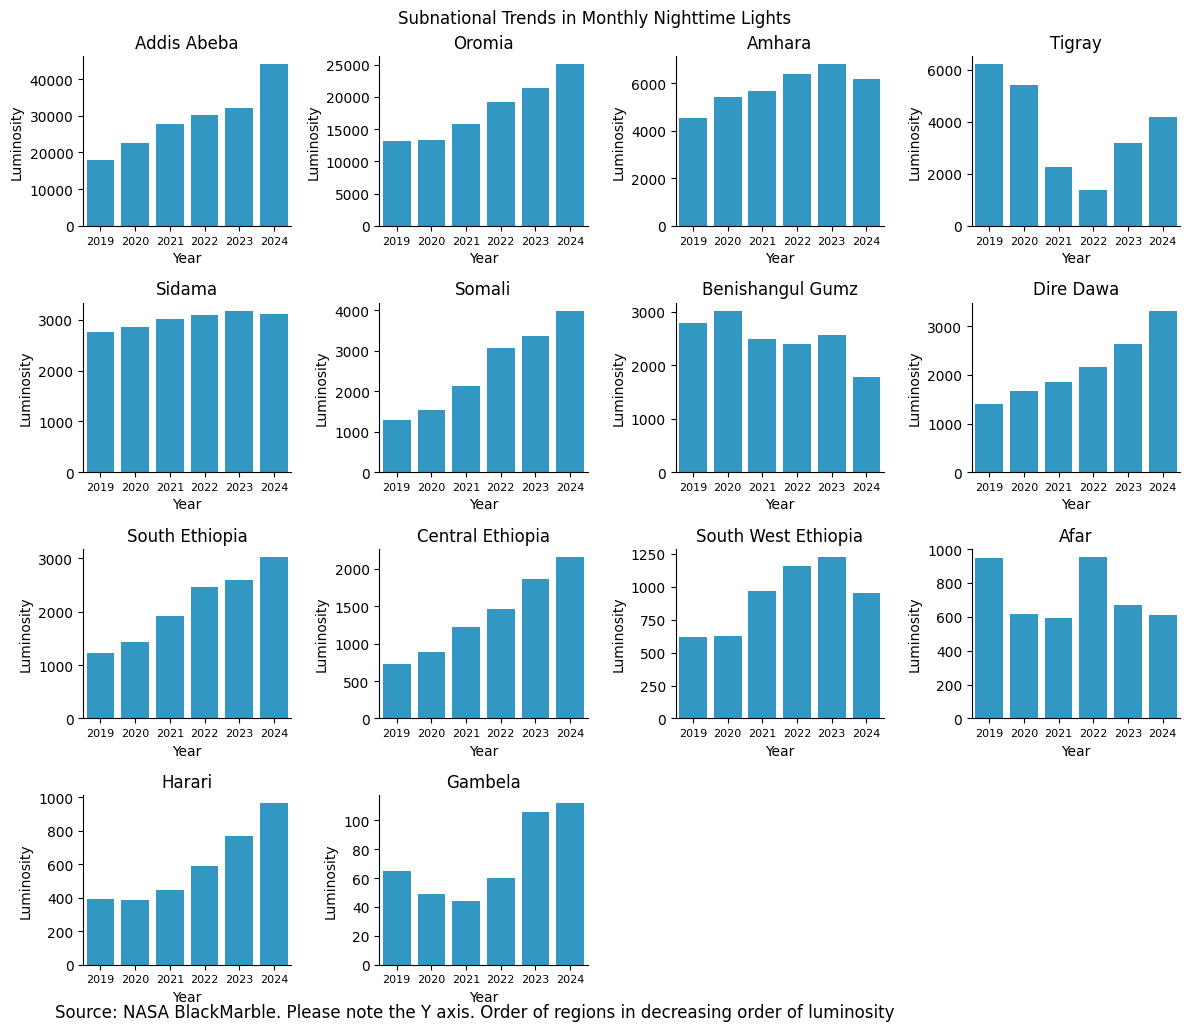

In [96]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Calculate total lights per region and sort regions in decreasing order
region_totals = ntl_adm1_annual.groupby("ADM1_EN")["ntl_sum"].sum().sort_values(ascending=False)
sorted_regions = region_totals.index.tolist()

fig, axes = plt.subplots(4, 4, figsize=(12, 10))  # 4x3 grid (extra space for alignment)
axes = axes.flatten()

# Create bar charts for each region in sorted order
for i, region in enumerate(sorted_regions):
    ax = axes[i]
    df = ntl_adm1_annual[ntl_adm1_annual["ADM1_EN"] == region]
    df.loc[:, "year"] = pd.to_datetime(df["date"]).dt.year

    sns.barplot(data=df, x="year", y="ntl_sum", color="#1AA1DB", ax=ax)
    ax.set_title(region)
    ax.set_xlabel("Year")
    ax.set_ylabel("Luminosity")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.tick_params(axis="x", labelsize=8)

# Hide extra subplots if regions < grid cells
for j in range(len(sorted_regions), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.suptitle("Subnational Trends in Monthly Nighttime Lights", x=0.5, y=1.01)

# Add subtitle below the main title
plt.figtext(0.4, 0.002, "Source: NASA BlackMarble. Please note the Y axis. Order of regions in decreasing order of luminosity", ha="center", fontsize=12, color="black")

plt.show()

#
# plt.savefig('../../docs/images/ntl_admin1_monthly.png')

**There was a considerable increase in light in Afar in 2017. Most other regions also saw an increase in light in that year.** Somali and SNNR has shown a consistent rise in NTL. Tigray region saw a drop in NTL in 2022, potentially because of the war. 

#### Monthly Trends in Nighttime Lights from 2019

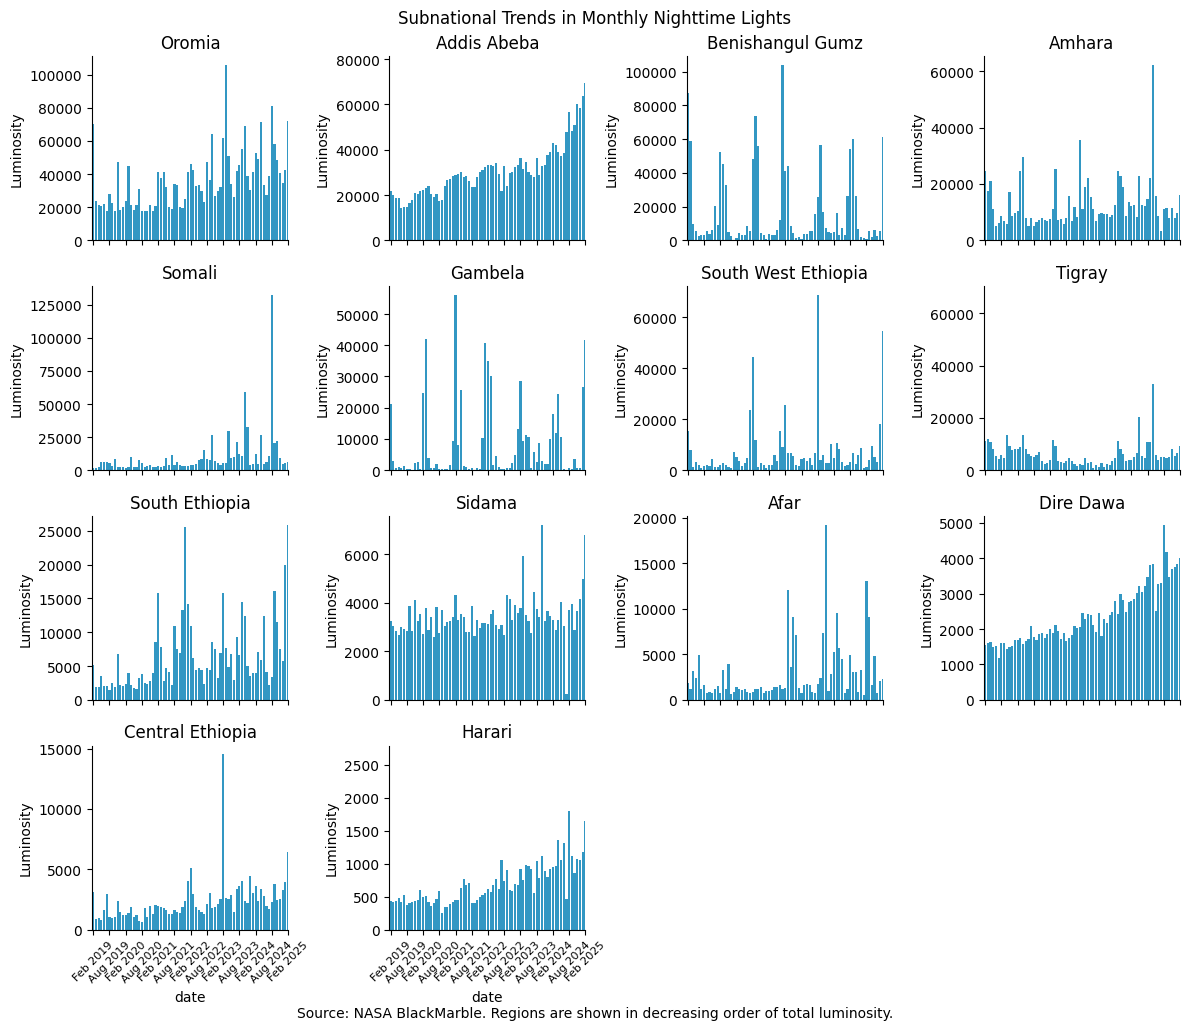

In [124]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(4, 4, figsize=(12, 10), sharex=True)  # 4x3 grid (extra space for alignment)
axes = axes.flatten()

ntl_adm1_monthly.sort_values(by='date', inplace=True)

# Calculate total luminosity per region and sort in decreasing order
region_totals = ntl_adm1_monthly.groupby("ADM1_EN")["ntl_sum"].sum().sort_values(ascending=False)
sorted_regions = region_totals.index.tolist()

# Create bar charts for each region in sorted order
for i, region in enumerate(sorted_regions):
    ax = axes[i]
    df = ntl_adm1_monthly[ntl_adm1_monthly["ADM1_EN"] == region]
    df = df[df["date"] > "2019-01-01"]
    df.loc[:, "year"] = pd.to_datetime(df["date"]).dt.year

    sns.barplot(data=df, x="date", y="ntl_sum", color="#1AA1DB", ax=ax)
    ax.set_title(region)
    ax.set_ylabel("Luminosity")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    tick_positions = range(0, len(df["date"]), 6)  # Every 6th month
    tick_labels = (
        pd.to_datetime(df["date"]).iloc[tick_positions].dt.strftime("%b %Y")
    )  # Format as 'Month Year'
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels, rotation=45, fontsize=8)

# Hide extra subplots if regions < grid cells
for j in range(len(sorted_regions), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.suptitle("Subnational Trends in Monthly Nighttime Lights", x=0.5, y=1.01, fontsize=12)
# Add note below the plot
plt.figtext(0.5, 0.002, "Source: NASA BlackMarble. Regions are shown in decreasing order of total luminosity.", ha="center", fontsize=10, color="black")
plt.show()
# plt.savefig('../../docs/images/ntl_admin1_monthly.png')

In [68]:
import geopandas as gpd

ethiopia_adm1 = gpd.read_file(
    "../../data/boundaries/Region_14/Regions_14.shp"
)
ethiopia_adm2 = gpd.read_file(
    "../../boundaries/adm2_mapped.geojson"
)
ethiopia_adm3 = gpd.read_file(
    "../../boundaries/adm3_mapped.geojson"
)

In [72]:
# ntl_adm1_annual.drop(columns='geometry', inplace=True)
# ntl_adm2_annual.drop(columns='geometry', inplace=True)

ntl_admin1_annual_gdf = ntl_adm1_annual.merge(
    ethiopia_adm1[["ADM0_EN", "ADM1_EN", "geometry"]], on=[ "ADM1_EN"]
)
ntl_admin2_annual_gdf = ntl_adm2_annual.merge(
    ethiopia_adm2[[ "ADM1_EN", "ADM2_EN", "geometry"]],
    on=[ "ADM1_EN", "ADM2_EN"],
)

In [74]:
# ntl_adm1_monthly.drop(columns="geometry", inplace=True)
# ntl_adm2_monthly.drop(columns="geometry", inplace=True)

ntl_admin1_monthly_gdf = ntl_adm1_monthly.merge(
    ethiopia_adm1[[ "ADM1_EN", "geometry"]], on=["ADM1_EN"]
)
ntl_admin2_monthly_gdf = ntl_adm2_monthly.merge(
    ethiopia_adm2[["ADM1_EN", "ADM2_EN", "geometry"]],
    on=["ADM1_EN", "ADM2_EN"],
)

In [75]:
from shapely.geometry import Polygon, Point

ntl_admin1_annual_gdf = gpd.GeoDataFrame(ntl_admin1_annual_gdf, geometry="geometry")
ntl_admin2_annual_gdf = gpd.GeoDataFrame(ntl_admin2_annual_gdf, geometry="geometry")

In [76]:
ntl_admin1_monthly_gdf = gpd.GeoDataFrame(ntl_admin1_monthly_gdf, geometry="geometry")
ntl_admin2_monthly_gdf = gpd.GeoDataFrame(ntl_admin2_monthly_gdf, geometry="geometry")

#### Geospatial Representation of Nighttime Lights

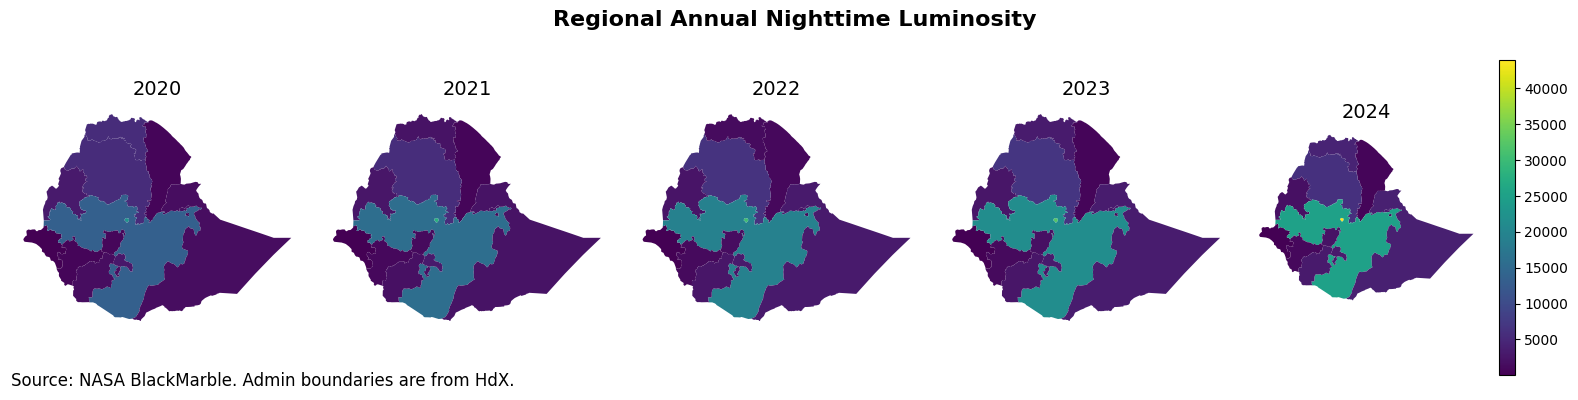

In [112]:
import matplotlib.pyplot as plt
import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# Define the custom colors
colors = ["#754493", "#A873C4", "#D1AEE3", "#EFEFEF", "#98CBCC", "#4EA2AC", "#24768E"]


# Create the custom colormap
custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", colors, N=256)

# Define the years to loop through
years = [2020, 2021, 2022, 2023, 2024]


# Calculate vmin and vmax for consistent color scaling
vmin = ntl_admin1_annual_gdf[ntl_admin1_annual_gdf["date"] > "2019-01-01"][
    "ntl_sum"
].min()
vmax = ntl_admin1_annual_gdf[ntl_admin1_annual_gdf["date"] > "2019-01-01"][
    "ntl_sum"
].max()

# Create subplots
fig, axes = plt.subplots(
    1, 5, figsize=(16, 4), gridspec_kw={"width_ratios": [1, 1, 1, 1, 1]}
)  # 2 rows, 2 columns for 4 subplots
axes = axes.flatten()  # Flatten for easy indexing

for idx, year in enumerate(years):
    # Filter the GeoDataFrame for the given year
    filtered_data = ntl_admin1_annual_gdf[
        ntl_admin1_annual_gdf["date"] == f"{year}-01-01"
    ]

    # Add the legend only to the last plot
    legend = idx == len(years) - 1

    # Plot on the respective subplot
    filtered_data.plot(
        column="ntl_sum",
        ax=axes[idx],
        legend=legend,  # Add legend only for the last plot
        vmin=vmin,
        vmax=vmax,
        cmap="viridis",  # Adjust color map as needed
    )
    axes[idx].set_title(f"{year}", fontsize=14)  # Set title to just the year
    axes[idx].axis("off")

# Add a main title
fig.suptitle("Regional Annual Nighttime Luminosity", fontsize=16, y=0.95, fontweight="bold")

plt.figtext(
    0.01,
    0.01,
    "Source: NASA BlackMarble. Admin boundaries are from HdX.",
    ha="left",
    fontsize=12,
)


# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the main title
plt.show()


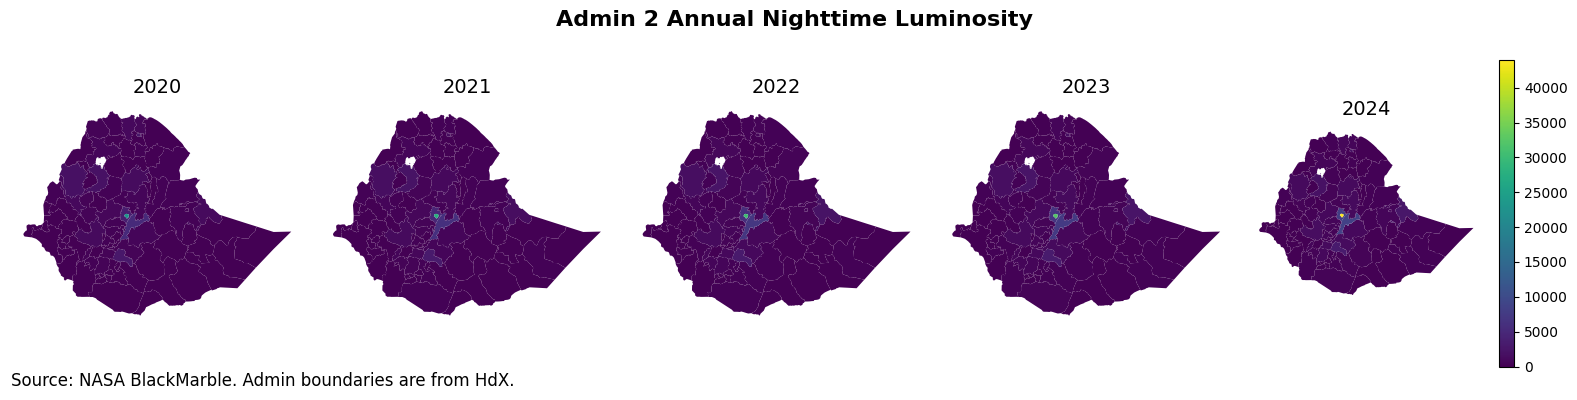

In [ ]:
import matplotlib.pyplot as plt
import geopandas as gpd

import matplotlib.colors as mcolors
import numpy as np

# Define the custom colors
colors = ["#754493", "#A873C4", "#D1AEE3", "#EFEFEF", "#98CBCC", "#4EA2AC", "#24768E"]

# Create the custom colormap
custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", colors, N=256)

# Define the years to loop through
years = [2020, 2021, 2022, 2023, 2024]

# Calculate vmin and vmax for consistent color scaling
vmin = ntl_admin2_annual_gdf[ntl_admin2_annual_gdf["date"] > "2019-01-01"]["ntl_sum"].min()
vmax_values = ntl_admin2_annual_gdf[ntl_admin2_annual_gdf["date"] > "2019-01-01"].groupby("ADM2_EN")["ntl_sum"].max()

# Sort regions by decreasing vmax
sorted_regions = vmax_values.sort_values(ascending=False).index.tolist()

fig, axes = plt.subplots(1, 5, figsize=(16, 4), gridspec_kw={"width_ratios": [1, 1, 1, 1, 1]})
axes = axes.flatten()

for idx, year in enumerate(years):
    # Filter the GeoDataFrame for the given year
    filtered_data = ntl_admin2_annual_gdf[ntl_admin2_annual_gdf["date"] == f"{year}-01-01"]
    # Reorder by sorted_regions
    filtered_data = filtered_data.set_index("ADM2_EN").loc[sorted_regions].reset_index()

    legend = idx == len(years) - 1

    filtered_data.plot(
        column="ntl_sum",
        ax=axes[idx],
        legend=legend,
        vmin=vmin,
        vmax=filtered_data["ntl_sum"].max(),
        cmap="viridis",
    )
    axes[idx].set_title(f"{year}", fontsize=14)
    axes[idx].axis("off")

fig.suptitle("Admin 2 Annual Nighttime Luminosity", fontsize=16, y=0.95, fontweight="bold")
plt.figtext(
    0.01,
    0.01,
    "Source: NASA BlackMarble. Admin boundaries are from HdX.",
    ha="left",
    fontsize=12,
)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

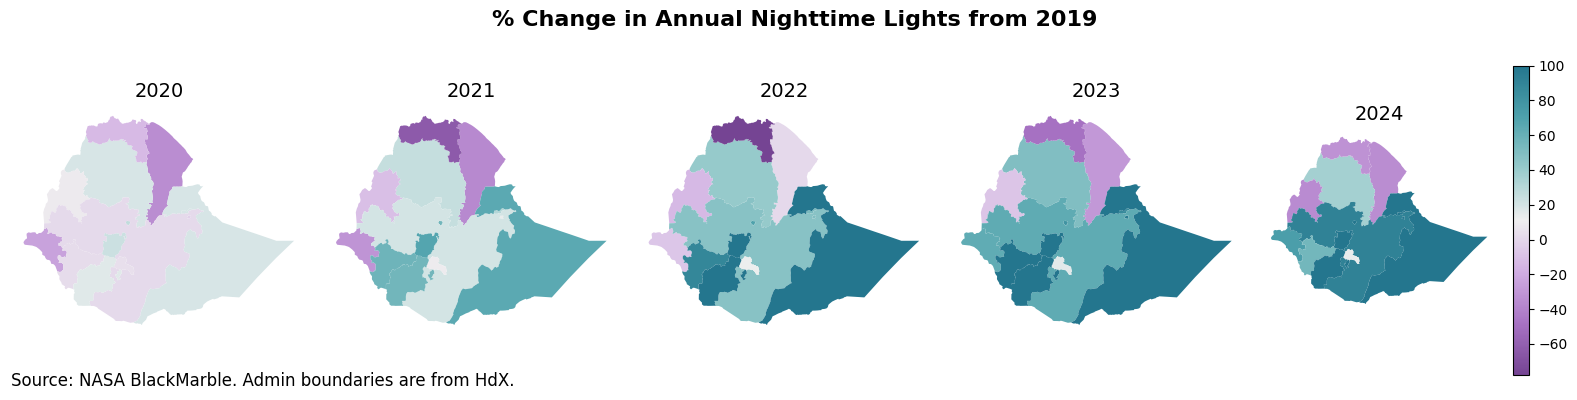

In [80]:
import matplotlib.pyplot as plt
import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# Define the custom colors
colors = ["#754493", "#A873C4", "#D1AEE3", "#EFEFEF", "#98CBCC", "#4EA2AC", "#24768E"]


# Create the custom colormap
custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", colors, N=256)

# Define the years to loop through
years = [2020, 2021, 2022, 2023, 2024]


# Calculate vmin and vmax for consistent color scaling
vmin = ntl_admin1_annual_gdf[ntl_admin1_annual_gdf["date"] > "2019-01-01"][
    "percent_change_ntl_sum_2019"
].min()
vmax = 100  # ntl_admin1_annual_gdf[ntl_admin1_annual_gdf['date']>'2019-01-01']['percent_change'].max()

# Create subplots
fig, axes = plt.subplots(
    1, 5, figsize=(16, 4), gridspec_kw={"width_ratios": [1, 1, 1, 1, 1]}
)  # 2 rows, 2 columns for 4 subplots
axes = axes.flatten()  # Flatten for easy indexing

for idx, year in enumerate(years):
    # Filter the GeoDataFrame for the given year
    filtered_data = ntl_admin1_annual_gdf[
        ntl_admin1_annual_gdf["date"] == f"{year}-01-01"
    ]

    # Add the legend only to the last plot
    legend = idx == len(years) - 1

    # Plot on the respective subplot
    filtered_data.plot(
        column="percent_change_ntl_sum_2019",
        ax=axes[idx],
        legend=legend,  # Add legend only for the last plot
        vmin=vmin,
        vmax=vmax,
        cmap=custom_cmap,  # Adjust color map as needed
    )
    axes[idx].set_title(f"{year}", fontsize=14)  # Set title to just the year
    axes[idx].axis("off")

# Add a main title
fig.suptitle(
    "% Change in Annual Nighttime Lights from 2019",
    fontsize=16,
    y=0.95,
    fontweight="bold",
)

plt.figtext(
    0.01,
    0.01,
    "Source: NASA BlackMarble. Admin boundaries are from HdX.",
    ha="left",
    fontsize=12,
)


# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the main title
plt.show()


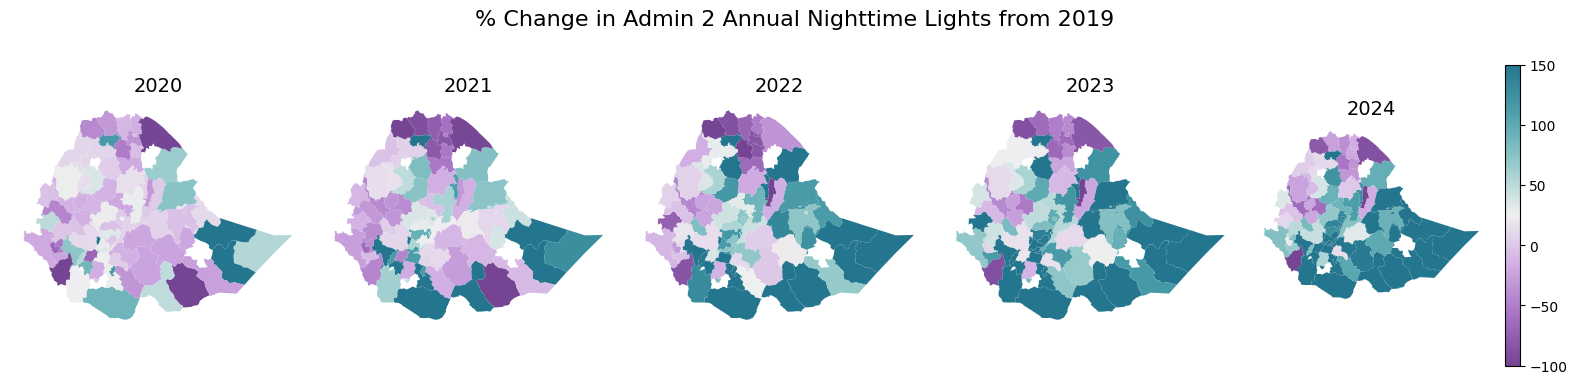

In [113]:
import matplotlib.pyplot as plt
import geopandas as gpd

# Define the years to loop through
years = [2020, 2021, 2022, 2023, 2024]

# Calculate vmin and vmax for consistent color scaling
vmin = ntl_admin2_annual_gdf[ntl_admin2_annual_gdf["date"] > "2019-01-01"][
    "percent_change_ntl_sum_2019"
].min()
vmax = 150  # ntl_admin2_annual_gdf[ntl_admin2_annual_gdf['date']>'2019-01-01']['percent_change'].max()

# Create subplots
fig, axes = plt.subplots(1, 5, figsize=(16, 4))  # 2 rows, 2 columns for 4 subplots
axes = axes.flatten()  # Flatten for easy indexing

for idx, year in enumerate(years):
    # Filter the GeoDataFrame for the given year
    filtered_data = ntl_admin2_annual_gdf[
        ntl_admin2_annual_gdf["date"] == f"{year}-01-01"
    ]

    # Add the legend only to the last plot
    legend = idx == len(years) - 1

    # Plot on the respective subplot
    filtered_data.plot(
        column="percent_change_ntl_sum_2019",
        ax=axes[idx],
        legend=legend,  # Add legend only for the last plot
        vmin=vmin,
        vmax=vmax,
        cmap=custom_cmap,  # Adjust color map as needed
    )
    axes[idx].set_title(f"{year}", fontsize=14)  # Set title to just the year
    axes[idx].axis("off")

# Add a main title
fig.suptitle("% Change in Admin 2 Annual Nighttime Lights from 2019", fontsize=16, y=0.95)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the main title
plt.show()


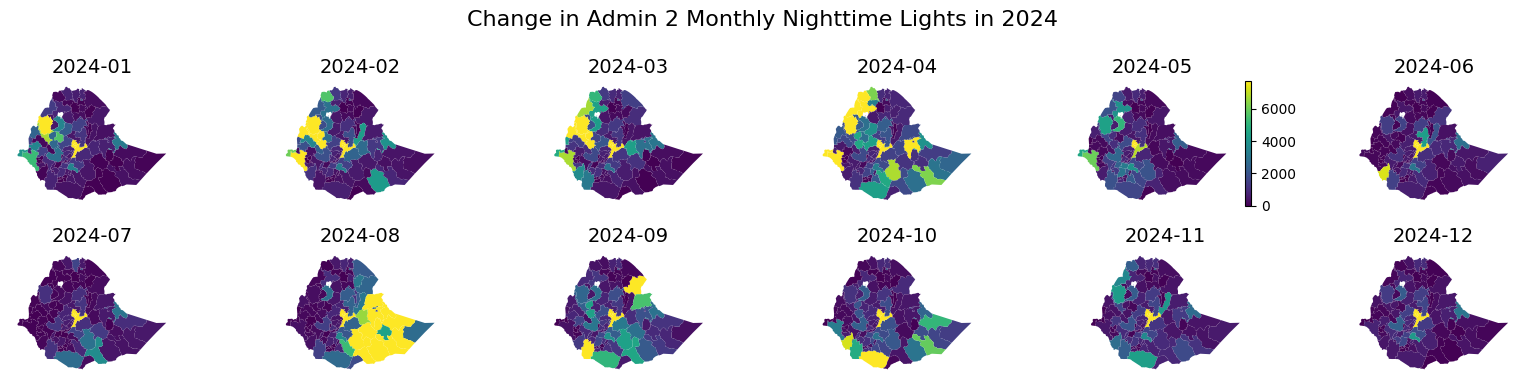

In [114]:
import matplotlib.pyplot as plt
import geopandas as gpd

# Define the years to loop through
months_2024 = (
    pd.date_range("2024-01-01", periods=12, freq="MS").strftime("%Y-%m").tolist()
)


df = ntl_admin2_monthly_gdf.copy()
df = df[(df["date"] > "2023-12-31")]

# Calculate vmin and vmax for consistent color scaling
vmin = df["ntl_sum"].min()
vmax = df["ntl_sum"].max() / 10

# Create subplots
fig, axes = plt.subplots(2, 6, figsize=(16, 4))  # 2 rows, 2 columns for 4 subplots
axes = axes.flatten()  # Flatten for easy indexing

for idx, month in enumerate(months_2024):
    # Filter the GeoDataFrame for the given year
    filtered_data = df[df["date"] == month]

    # Add the legend only to the last plot
    legend = idx == len(years) - 1

    # Plot on the respective subplot
    filtered_data.plot(
        column="ntl_sum",
        ax=axes[idx],
        legend=legend,  # Add legend only for the last plot
        vmin=vmin,
        vmax=vmax,
        cmap="viridis",  # Adjust color map as needed
    )
    axes[idx].set_title(f"{month}", fontsize=14)  # Set title to just the year
    axes[idx].axis("off")

# Add a main title
fig.suptitle("Change in Admin 2 Monthly Nighttime Lights in 2024", fontsize=16, y=0.95)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the main title
plt.show()
